# Дисклеймер
Эту тетрадку нужно запускать в колабе или в vast.ai. Не мучатесь с установкой библиотек и с обучением на cpu.

Я разбирался в торче пока делал этот семинар, так что относитесь к моим наработкам как к обучающему материалу, а не стандарту. Скорее всего, есть более правильные, эффективные, красивые решения. 

In [1]:
!pip install torch torch-vision

     |█████████████▋                  | 342.3 MB 79.2 MB/s eta 0:00:066

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |██████████████████████████▍     | 663.3 MB 84.6 MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 804.1 MB 113.4 MB/s eta 0:00:01     |████████████████████████████████| 804.1 MB 34 kB/s 
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!apt-get install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [3]:
!unzip data.zip

Archive:  data.zip
  inflating: lenta_sample.csv        
  inflating: __MACOSX/._lenta_sample.csv  


In [4]:
!pip install pandas scikit-learn matplotlib

     |████████████████████████████████| 9.5 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 22.2 MB 51.2 MB/s eta 0:00:01
     |████████████████████████████████| 11.5 MB 58.7 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 58.1 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 50.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 49.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 58.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Сверточные нейронные сети

Несколько полносвязных слоев (с нелинейностями посередине) - это уже полноценная нейронная сеть. Однако это скорее какая-то базовая вещь. Действительно нужен полносвязный слой только в конце сети, а в качестве основных используются сверточные или рекуррентные слои. Главное их отличие (=преимущество) - учитывание структукры данных. В этом семинаре мы попробуем использовать сверточные сети. Лучше всего они работают в картинках, но для текстов их тоже можно применять (они быстрее рекуррентных и могут лучше работать на длинных последовательностях).

Про то как работают сверточные слои посмотрите в этом видео - https://www.youtube.com/watch?v=bNb2fEVKeEo

Основная идея - использовать много небольших (сильно меньше размера текста или картинки) матриц, которые применяются к кусочкам векторизованного текста/картинки. Между кусочком и матрицей считается близость, и эта близость передается дальше по сети. Т.е. кусочек как-бы **сворачивается** в одно число. 

Эти небольшие матрицы обучаются на данных и, например, для картинок в них собираются различные паттерны, важные для задачи. Например, для определения рукописных цифр, такие матрицы могут представлять горизонтальные черточки, волнистые линии, кружки и т.д. Есть даже целое направление исследований, которое занимается визуализацией и интерпретацией обученных сверток.

Из-за того, что матрицы применяются к кусочкам, а не отедльным элементам, гораздо лучше учитывается структура. 

## Классификация с помощью CNN

Давайте посмотрим, как в торче использовать сверточные сети и как их соединять с Embedding и Linear слоями.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [6]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# данные - статьи из ленты ру, нужно предсказать категорию новости
data = pd.read_csv('lenta_sample.csv')

In [8]:
data.dropna(subset=['topic', 'text'], inplace=True)

Предобработка нам тут особо не важна.

In [9]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

В предыдущей домашке не хватало фмеры. Ее нет в керасе, но можно взять вот такую функцию (взятую со стаковерфлоу)

Предобработка точно такая же

In [10]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [11]:
len(vocab)

670782

In [12]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [13]:
len(filtered_vocab)

55293

In [14]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [15]:
id2word = {i:word for word, i in word2id.items()}

Обертка для данных - такая же как и в предыдущем семинаре

In [16]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, word2id, MAX_LEN, texts, targets):
        
        # храним сырой датасет
        # еще лучше можно сделать, если считывать из файла при генерации
        self.texts = [torch.LongTensor([word2id[w] for w in self.preprocess(t) if w in word2id][:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)
        
        # мы не считаем словарь прямо тут, т.к. нам нужно шерить словарь между трейном и валидацией
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        # таргеты можно сразу целиком выделить 
        
        self.target = torch.LongTensor(targets)

    def __len__(self):
        # нужно уметь возвращать длину датасета, в нашем случае это просто сделать
        # если не загружать данные целиком, а читать из файла - это может быть сложнее
        return self.length

    def __getitem__(self, index):

        # в index будут индексы от 0 до self.length
        # по ним мы достанем тексты, предобработаем,переведем в векторы, западим и вернем

        ids = self.texts[index]
        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens


In [17]:
MAX_LEN = 200

In [18]:
texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

In [19]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

In [20]:
training_set = Dataset(word2id, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=256, shuffle=True, )

In [21]:
valid_set = Dataset(word2id, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=True)

Для сравнения сначала обучим сеть только с помощью Dense слоев. Трейн луп такой же как и в предыдущем семинаре

In [22]:
from sklearn.metrics import f1_score

def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions, ys.to(device))        
        
        
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')
        
    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            

            epoch_loss.append(loss.item())  
            epoch_f1.append(f1_score(y_true, preds, average="micro"))
            
    return np.mean(epoch_f1)# / len(iterator)

In [23]:
# сеть с двумя полносвязными слоями и активацией
class Clf(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden, output_dim):
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, hidden)
        self.fc_1 = nn.Linear(hidden, output_dim)
        self.act = nn.LogSoftmax(1) 
        self.relu = nn.ReLU()       
        
    def forward(self, text):
        embedded = self.embedding(text)   
        hidden = torch.mean(embedded, dim=1)
        hidden = self.relu(self.fc(hidden))
        dense_outputs=self.fc_1(hidden) 

        outputs=self.act(dense_outputs)
        
        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(word2id), 30, 30, len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

Запускаем обучение

In [24]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Loss: 2.6197411823272705; F1 measure: 0.1808203125
Loss: 2.4586977422237397; F1 measure: 0.19806640625
Loss: 2.373960111141205; F1 measure: 0.20907552083333333
Loss: 2.293777464926243; F1 measure: 0.235419921875
Loss: 2.1999969239234924; F1 measure: 0.2706328125
Eval -  0.46314655172413793
1
Loss: 1.5232779133319854; F1 measure: 0.5215234375
Loss: 1.4571399873495101; F1 measure: 0.54337890625
Loss: 1.4014333546161652; F1 measure: 0.5609895833333334
Loss: 1.355219143331051; F1 measure: 0.57517578125
Loss: 1.313402940273285; F1 measure: 0.588875
Eval -  0.6512631704980844
2
Loss: 1.0344296985864638; F1 measure: 0.6799609375
Loss: 1.0047901949286462; F1 measure: 0.68927734375
Loss: 0.9862580219904582; F1 measure: 0.6943098958333334
Loss: 0.9652436164021492; F1 measure: 0.701083984375
Loss: 0.9504220184087754; F1 measure: 0.705734375
Eval -  0.7233494971264368
3
Loss: 0.8189972084760666; F1 measure: 0.74671875
Loss: 0.812115375995636; F1 measure: 0.7473046875
Loss: 0.8023925479253133; F1

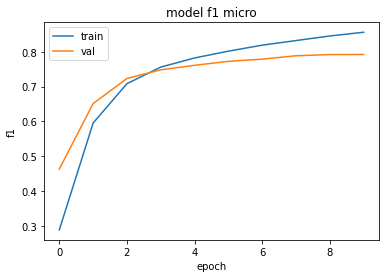

In [25]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Посмотрим еще максимальную f меру

In [26]:
max(f1s_eval)

0.7923473419540229

Теперь попробуем сверточные слои. В торче сверточные слои не очень простые - нужно подробно разобраться в параметрах и расчитывать изменения в размере последовательности вручную. 

In [67]:
class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__() 
        # параметры лучше передавать снаружи
        # но для простоты напишем тут
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100 # размерность эмбединга слов
        self.KERNEL_SIZE = 10 # размер фильтров в CNN, влияет на выходную длину последовательности
        self.MAX_LEN = 200 # длина последовательности до которой западили 
        self.IN_CHANNELS = self.EMB_DIM # параметр который нужно передать в CNN, соответствующий размеру эмбединга
        self.OUT_CHANNELS = 32 # количество фильтров в CNN, будет соответствовать размерности векторов на выходе из CNN
        self.STRIDE = 1 # параметр CNN влияющий на выходную длину последовательности
        self.HIDDEN_FC = 64 # перед финальной классификацией поставим еще один полносвязный слой
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        self.conv = nn.Conv1d(self.IN_CHANNELS, 
                              self.OUT_CHANNELS, 
                              kernel_size=self.KERNEL_SIZE, 
                              stride=self.STRIDE, ) 
        
        # к выходу из CNN и к выходу промежуточного полносвязного слоя нужно применить активацию
        self.relu = nn.ReLU() 
        
        
        # расчитываем по формуле размерность получившейся последовательности
        # умножаем на OUT_CHANNELS чтобы получить размер вектора
        # который получиться если конкатенировать все в 1 вектор
        
        
        self.flattened_size = int((((self.MAX_LEN-(self.KERNEL_SIZE-1)-1)/self.STRIDE)+1)*self.OUT_CHANNELS)
        
        # используем размер вектора для определения полносвязного слоя
        self.fc = nn.Linear(self.flattened_size, 
                            self.HIDDEN_FC)
        
        self.fc_1 = nn.Linear(self.HIDDEN_FC, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):
        
        # сверточный слой ожидает на вход последовательность такого вида
        # (batch_size, emb_dim, max_len)
        # а у нас получается 
        # (batch_size, max_len, emb_dim)
        # поэтому используем permute чтобы поменять местами max_len и emb_dim
        embedded = self.embedding(text).permute(0, 2, 1)
        
        convoluted = self.relu(self.conv(embedded)) # пропускаем через свертку и применяем релу
        hidden = torch.flatten(convoluted, 1, -1) # конкатенируем
        hidden = self.relu(self.fc(hidden))  # подаем в полносвязный и применяем активацию
        
        dense_outputs = self.fc_1(hidden) 
        outputs=self.act(dense_outputs) 
        
        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [24]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Loss: 2.6197411823272705; F1 measure: 0.1808203125
Loss: 2.4586977422237397; F1 measure: 0.19806640625
Loss: 2.373960111141205; F1 measure: 0.20907552083333333
Loss: 2.293777464926243; F1 measure: 0.235419921875
Loss: 2.1999969239234924; F1 measure: 0.2706328125
Eval -  0.46314655172413793
1
Loss: 1.5232779133319854; F1 measure: 0.5215234375
Loss: 1.4571399873495101; F1 measure: 0.54337890625
Loss: 1.4014333546161652; F1 measure: 0.5609895833333334
Loss: 1.355219143331051; F1 measure: 0.57517578125
Loss: 1.313402940273285; F1 measure: 0.588875
Eval -  0.6512631704980844
2
Loss: 1.0344296985864638; F1 measure: 0.6799609375
Loss: 1.0047901949286462; F1 measure: 0.68927734375
Loss: 0.9862580219904582; F1 measure: 0.6943098958333334
Loss: 0.9652436164021492; F1 measure: 0.701083984375
Loss: 0.9504220184087754; F1 measure: 0.705734375
Eval -  0.7233494971264368
3
Loss: 0.8189972084760666; F1 measure: 0.74671875
Loss: 0.812115375995636; F1 measure: 0.7473046875
Loss: 0.8023925479253133; F1

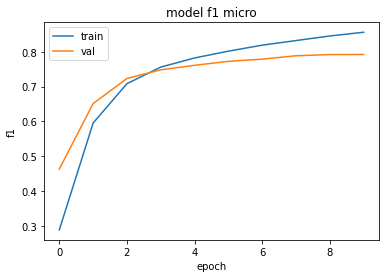

In [25]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
max(f1s_eval)

# Пулинг

Вместе с CNN слоями часто используют пулинг слои. По сути это такие же сверточные слои, но без обучаемой части. В CNN фильтры обучаются под конкретную задачу, а в пулинге фильтры фиксированы (как правило это стандартная функция - максимум, среднее). Например, MaxPooling будет брать кусочек входной последовательности и передавать дальше максимальное значение в этом кусочке.

Параметры пулинга практически такие же как и в CNN (kernel_size, stride), но нет in_channels, out_channels, так как размерность вектора никак не меняется. Расчитать длину последовательности после пулинга можно также как и в CNN - нужно знать длину входной последовательности, kernel_size и stride.

In [76]:
class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.KERNEL_SIZE = 5
        self.MAX_LEN = 200
        self.IN_CHANNELS = self.EMB_DIM
        self.OUT_CHANNELS = 128
        self.STRIDE = 2
        self.STRIDE_POOL = 2
        self.KERNEL_SIZE_POOL = 2
        self.HIDDEN_FC = 64
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.conv = nn.Conv1d(self.IN_CHANNELS, 
                              self.OUT_CHANNELS, 
                              kernel_size=self.KERNEL_SIZE, 
                              stride=self.STRIDE) 
        
        # считаем длину после снн
        self.conv_length = int((((self.MAX_LEN-(self.KERNEL_SIZE-1)-1)/self.STRIDE)+1))
        
        
        # пулинг с максимумом
        self.max_pool = nn.MaxPool1d(kernel_size=self.KERNEL_SIZE_POOL, 
                                     stride=self.STRIDE_POOL) 
        # также считаем длину после пулинга
        self.pool_length = int((((self.conv_length-(self.KERNEL_SIZE_POOL-1)-1)/self.STRIDE_POOL)+1))
        
        
        # функций активации много 
        # релу самая популярная
        # у нее есть вариант с "протечкой"
        # в нем отрицательные значений зануляются не полностью
        # а с каким-то маленьким коэффициентом (0.05) например
        self.relu = torch.nn.LeakyReLU()
        
        
        # считаем размерность конкатенированного вектора
        # умножаем размерность вектора после CNN на длину последовательности после пулинга
        self.fc = nn.Linear(self.OUT_CHANNELS * self.pool_length, 
                            self.HIDDEN_FC)
        self.fc_1 = nn.Linear(self.HIDDEN_FC, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):
        embedded = self.embedding(text).permute(0, 2, 1)
        convoluted = self.relu(self.conv(embedded))
        pooled = self.max_pool(convoluted)
        hidden = torch.flatten(pooled, 1, -1)
        hidden = self.relu(self.fc(hidden))
        dense_outputs=self.fc_1(hidden) 
        outputs=self.act(dense_outputs)
        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [24]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Loss: 2.6197411823272705; F1 measure: 0.1808203125
Loss: 2.4586977422237397; F1 measure: 0.19806640625
Loss: 2.373960111141205; F1 measure: 0.20907552083333333
Loss: 2.293777464926243; F1 measure: 0.235419921875
Loss: 2.1999969239234924; F1 measure: 0.2706328125
Eval -  0.46314655172413793
1
Loss: 1.5232779133319854; F1 measure: 0.5215234375
Loss: 1.4571399873495101; F1 measure: 0.54337890625
Loss: 1.4014333546161652; F1 measure: 0.5609895833333334
Loss: 1.355219143331051; F1 measure: 0.57517578125
Loss: 1.313402940273285; F1 measure: 0.588875
Eval -  0.6512631704980844
2
Loss: 1.0344296985864638; F1 measure: 0.6799609375
Loss: 1.0047901949286462; F1 measure: 0.68927734375
Loss: 0.9862580219904582; F1 measure: 0.6943098958333334
Loss: 0.9652436164021492; F1 measure: 0.701083984375
Loss: 0.9504220184087754; F1 measure: 0.705734375
Eval -  0.7233494971264368
3
Loss: 0.8189972084760666; F1 measure: 0.74671875
Loss: 0.812115375995636; F1 measure: 0.7473046875
Loss: 0.8023925479253133; F1

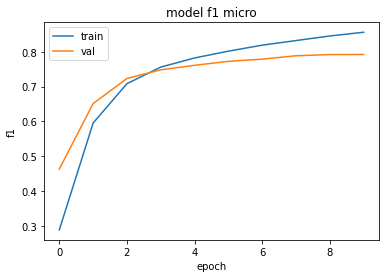

In [25]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [79]:
max(f1s_eval)

0.7615385536398468

# Регуляризация

Для того, чтобы сократить переобучение (а часто и просто чтобы улучшить качество) используют BatchNorm, DropOut и регуляризацию. 

DropOut - самый простой метод, он просто с какой-то вероятностью зануляет числа во входной матрице (есть еще dropout который зануляет рандомно, но уже сразу целиком какую-то размерность; в нашем случае он может например во всех эмбедингах занулить 2 и 5 элементы. Такой дропаут в торче называется DropOut2d). Использовать его очень легко - ```drop = nn.Dropout(0.3); drop(input)``` (также как relu в предыдущих примерах, но с 1 параметром). Для сверток Dropout однако почти не используют. 

В свертках используют BatchNorm. BatchNorm нормализует числа внутри батча так, чтобы они лежали в каком-то фиксированном интервале (от до 1). Это помогает сделать модель более устойчивой к изменениями во входных данных (например, если какое-то значение вдруг слишком сильно увеличится, то батчнорм не позволит ему слишком сильно повлиять на последующие слои), а также просто ускоряет обучение. Технически батчнорм не очень простой (там еще есть обучаемые параметры), вот несколько видео, если вам интересно разобраться -  https://www.youtube.com/watch?v=dXB-KQYkzNU , https://www.youtube.com/watch?v=nUUqwaxLnWs

Регуляризация - это ограничения на значения параметров в модели. В торче добавить L2 регуляризацию можно в оптимайзере, задав параметр weight_decay и указав веса какого слоя нужно регуляризировать. Скорее всего вам это не пригодится, но полезно знать про такую возможность.

Добавим батчнорм и регуляризацию.

In [103]:
class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.KERNEL_SIZE = 5
        self.MAX_LEN = 200
        self.IN_CHANNELS = self.EMB_DIM
        self.OUT_CHANNELS = 128
        self.STRIDE = 2
        self.STRIDE_POOL = 2
        self.KERNEL_SIZE_POOL = 2
        self.HIDDEN_FC = 64
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.conv = nn.Conv1d(self.IN_CHANNELS, 
                              self.OUT_CHANNELS, 
                              kernel_size=self.KERNEL_SIZE, 
                              stride=self.STRIDE) 
        self.conv_length = int((((self.MAX_LEN-(self.KERNEL_SIZE-1)-1)/self.STRIDE)+1))
        
        # инициализируем батчнорм
        self.batch_norm = nn.BatchNorm1d(self.conv_length)

        
        self.max_pool = nn.MaxPool1d(kernel_size=self.KERNEL_SIZE_POOL, 
                                     stride=self.STRIDE_POOL) 
        self.pool_length = int((((self.conv_length-(self.KERNEL_SIZE_POOL-1)-1)/self.STRIDE_POOL)+1))
        
        self.relu = torch.nn.LeakyReLU()
        

        self.fc = nn.Linear(self.OUT_CHANNELS * self.pool_length, 
                            self.HIDDEN_FC)
        self.fc_1 = nn.Linear(self.HIDDEN_FC, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):
        embedded = self.embedding(text).permute(0, 2, 1)
        convoluted = self.conv(embedded)
        # я не нашел совсем достоверной информации, но пару авторитетных мнений
        # указывают на то, что батчнорм нужно ставить после свертки-пулинга-активации
        # а не где-то внутри этой тройки
        # то есть нужно держаться структуры свертка-*пулинг*-активация-батчнорм (пулинг опциональный)
        pooled = self.batch_norm(self.relu(self.max_pool(convoluted)))
        hidden = torch.flatten(pooled, 1, -1)
        hidden = self.relu(self.fc(hidden))
        dense_outputs=self.fc_1(hidden) 
        outputs=self.act(dense_outputs)
        
        return outputs



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))


optimizer = optim.Adam([{'params':model.fc_1.parameters()},
                        {'params':model.conv.parameters()},
                        {'params':model.embedding.parameters()},
                        {'params': model.fc.parameters(), 'weight_decay':0.1}],  # указываем в этом слое L2 регуляризацию
                                                                                 # можно пробовать значения как в sklearn
                                                                                 # в параметре C в логреге
                       
                         lr=0.001) # лернирг рейт тоже можно отдельно указать выше, но мы используем 1 на все слои
criterion = nn.CrossEntropyLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [24]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Loss: 2.6197411823272705; F1 measure: 0.1808203125
Loss: 2.4586977422237397; F1 measure: 0.19806640625
Loss: 2.373960111141205; F1 measure: 0.20907552083333333
Loss: 2.293777464926243; F1 measure: 0.235419921875
Loss: 2.1999969239234924; F1 measure: 0.2706328125
Eval -  0.46314655172413793
1
Loss: 1.5232779133319854; F1 measure: 0.5215234375
Loss: 1.4571399873495101; F1 measure: 0.54337890625
Loss: 1.4014333546161652; F1 measure: 0.5609895833333334
Loss: 1.355219143331051; F1 measure: 0.57517578125
Loss: 1.313402940273285; F1 measure: 0.588875
Eval -  0.6512631704980844
2
Loss: 1.0344296985864638; F1 measure: 0.6799609375
Loss: 1.0047901949286462; F1 measure: 0.68927734375
Loss: 0.9862580219904582; F1 measure: 0.6943098958333334
Loss: 0.9652436164021492; F1 measure: 0.701083984375
Loss: 0.9504220184087754; F1 measure: 0.705734375
Eval -  0.7233494971264368
3
Loss: 0.8189972084760666; F1 measure: 0.74671875
Loss: 0.812115375995636; F1 measure: 0.7473046875
Loss: 0.8023925479253133; F1

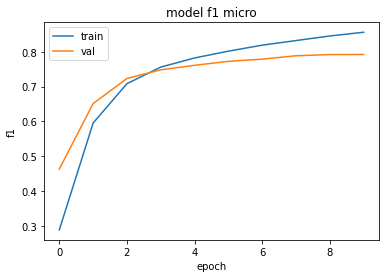

In [25]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [107]:
max(f1s_eval)

0.7343342911877394

### Несколько слоев с паддингом

Во всех сетках выше только 1 CNN слой и еще 1 доп. пулинг. Но рабочие сверточные сети это обычно десятки сверток и пулингов, которые наслаиваются друг на друга. Из когда выше видно, что собрать такую сетку будет непросто - будет очень много промежуточного когда для расчета размерностей. Чтобы этого избежать можно написать отдельный класс, который будет применять сверточный слой и сохранять длину последовательности. Для этого мы воспользуемся паддингом - добьем нулями исходную последовательность, чтобы на выходе получилась изначальная длина.

In [167]:
# созданный класс в торче можно использовать просто как слой!

class Conv_layer_with_pad(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        
        super().__init__()          
        self.KERNEL_SIZE = 7
        self.IN_CHANNELS = in_channels
        self.OUT_CHANNELS = 32
        self.STRIDE = 1
        self.conv = nn.Conv1d(self.IN_CHANNELS, 
                              self.OUT_CHANNELS, 
                              kernel_size=self.KERNEL_SIZE, 
                              stride=self.STRIDE, ) 
        
        self.act = nn.LeakyReLU()
        
    def forward(self, embedded):
        """
        Раньше мы расчитывали длину, которая получится, после применения сверточного слоя  по формуле:
        OUTPUT_LENGTH = (((MAX_LEN-(KERNEL_SIZE-1)-1)/STRIDE)+1)
        
        
        Теперь мы хотим на выходе получить длину, которая будет соответствовать длине изначальной последовательности.
        Т.е. мы знаем OUTPUT_LENGTH и наша задача найти такой MAX_LEN, при котором он получается (остальные параметры фиксированы)
        Перенесем все известные значения влево и получится вот такая формула
        ((OUTPUT_LENGTH-1)*STRIDE)+1+(KERNEL_SIZE-1) = MAX_LEN
        
        Используя нужное значение MAX_LEN, нам нужно допаддить изначальную последовательность до этой длины
        Т.к. мы будет падить с двух сторон, то нужно, чтобы получившееся число делилось на 2
        
        
        
        """
        MAX_LEN = embedded.size(2)
        EXP_LEN = ((MAX_LEN-1)*self.STRIDE)+1+(self.KERNEL_SIZE-1)

        # нужно чтобы все сходилось, иначе выдавать ошибку
        assert not (EXP_LEN-MAX_LEN)%2, f"Не ровный паддинг! {EXP_LEN}"
        
        # допустим чтобы получить изначальную длину в 200
        # нужно добавить нулей до 210
        # тогда мы добавляем 5 нулей слева и 5 справа
        # ассерт выше выкинул бы ошибку если бы у нас получалось например 209, 
        # то есть мы не смогли бы ровно западить с 2 сторон
        padded = F.pad(embedded, (int((EXP_LEN-MAX_LEN)/2), 
                                                   int((EXP_LEN-MAX_LEN)/2)))
        
        convoluted = self.conv(padded)
        
        return self.act(convoluted)


class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.KERNEL_SIZE = 7
        self.MAX_LEN = 200
        self.IN_CHANNELS = self.MAX_LEN
        self.OUT_CHANNELS = 32
        self.STRIDE = 1
        self.HIDDEN_FC = 64
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        # теперь слои удобно стакать
        # нужно только указывать OUT_CHANNELS как IN_CHANNELS в следующем слое
        self.conv = Conv_layer_with_pad(self.EMB_DIM, self.OUT_CHANNELS)
        self.conv1 = Conv_layer_with_pad(self.OUT_CHANNELS, 16)
        self.relu = nn.ReLU()
        # если бы мы поставили еще 1 слой, то его IN_CHANNELS была бы 16 и тд

        # длина сохраняется поэтому просто умножаем макс лен на OUT_CHANNELS последнего слоя
        self.flattened_size = int(self.MAX_LEN*16)
        
        self.fc = nn.Linear(self.flattened_size, 
                            self.HIDDEN_FC)
        self.fc_1 = nn.Linear(self.HIDDEN_FC, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        convoluted = self.relu(self.conv1(self.conv(embedded.permute(0, 2, 1))))
        hidden = torch.flatten(convoluted, 1, -1)
        hidden = torch.relu(self.fc(hidden))
        dense_outputs=self.fc_1(hidden) 
        outputs=self.act(dense_outputs)

        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 

model = model.to(device)
criterion = criterion.to(device)

In [24]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Loss: 2.6197411823272705; F1 measure: 0.1808203125
Loss: 2.4586977422237397; F1 measure: 0.19806640625
Loss: 2.373960111141205; F1 measure: 0.20907552083333333
Loss: 2.293777464926243; F1 measure: 0.235419921875
Loss: 2.1999969239234924; F1 measure: 0.2706328125
Eval -  0.46314655172413793
1
Loss: 1.5232779133319854; F1 measure: 0.5215234375
Loss: 1.4571399873495101; F1 measure: 0.54337890625
Loss: 1.4014333546161652; F1 measure: 0.5609895833333334
Loss: 1.355219143331051; F1 measure: 0.57517578125
Loss: 1.313402940273285; F1 measure: 0.588875
Eval -  0.6512631704980844
2
Loss: 1.0344296985864638; F1 measure: 0.6799609375
Loss: 1.0047901949286462; F1 measure: 0.68927734375
Loss: 0.9862580219904582; F1 measure: 0.6943098958333334
Loss: 0.9652436164021492; F1 measure: 0.701083984375
Loss: 0.9504220184087754; F1 measure: 0.705734375
Eval -  0.7233494971264368
3
Loss: 0.8189972084760666; F1 measure: 0.74671875
Loss: 0.812115375995636; F1 measure: 0.7473046875
Loss: 0.8023925479253133; F1

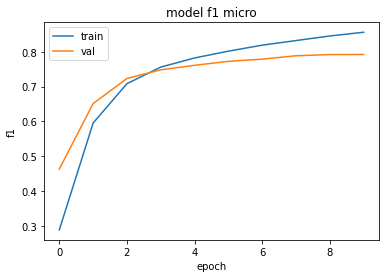

In [25]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [107]:
max(f1s_eval)

0.7343342911877394

## Домашнее задание

Соберите 1 сетку со всеми разобранными элементами - несколькими свертками, пулингами, батчнормами, активациями, дропаутами и регуляризацией. В вашей архитектуре должны быть как наслоенные (CNN-CNN-CNN-POOLING, например) друг на друга, так и параллельные элементы (CNN-POOLING; CNN-POOLING с конткатенацией выходов первого и второго перед flatten в 1 вектор) 

Запустите обучение и напечатайте результат. Важно, чтобы получилось не хуже, чем на картинках выше (т.е. качество хотя бы 0.75)